In [1]:
# Tests extract step itself, given known matrices

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsmr
import time
from astropy.io import fits

from scipy.sparse import diags

In [2]:

# no noise, small footprint:
'''
file_name_empirical = "stellar_empirical_no_noise_small_footprint.pkl"
file_name = "white_light_no_noise_small_footprint.pkl"
'''


# no noise, large footprint:
file_name_empirical = "stellar_empirical_no_noise.pkl"
file_name = "white_light_no_noise.pkl"


In [3]:
# retrieve instrument response matrix

open_file = open(file_name, "rb")

# response matrix, test commands, 2D detector test response
A_mat, test_cmds, test_response = pickle.load(open_file)
open_file.close()

# kludge: transpose
A_mat = A_mat.T

In [4]:
np.shape(test_response)

(100, 38, 1000)

In [5]:
test_response[0,10,10]

0.0

In [4]:
# retrieve 'empirical data'

open_file = open(file_name_empirical, "rb")

empirical_2d_array = pickle.load(open_file)[0]

open_file.close()

In [9]:
np.shape(np.random.normal(size=(np.shape(empirical_2d_array)[0],np.shape(empirical_2d_array)[1])))

(38, 1000)

In [15]:

# add noise

array_size = np.shape(np.random.normal(size=(np.shape(empirical_2d_array)[0],np.shape(empirical_2d_array)[1])))
empirical_2d_array += (np.max(empirical_2d_array)/20.)*np.random.normal(size=array_size)


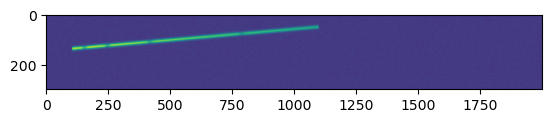

In [6]:
plt.imshow(empirical_2d_array)
plt.show()

In [7]:
print(np.max(empirical_2d_array))
print(np.std(empirical_2d_array[:10,:10]))
print(empirical_2d_array[10,10])

87.56753257176271
3.4788283176756103
7.447527328214261


In [35]:
'''
# write to FITS to check

hdu = fits.PrimaryHDU(empirical_2d_array)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_empirical_2d_array.fits')

hdu = fits.PrimaryHDU(test_response)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_test_response.fits')
'''

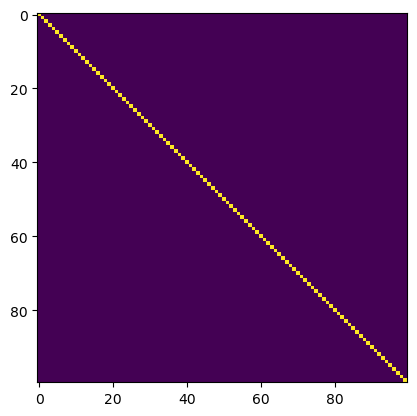

In [6]:
plt.imshow(test_cmds)
plt.show()

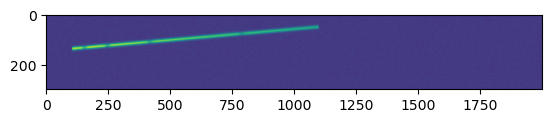

In [8]:
plt.imshow(empirical_2d_array)
plt.savefig("junk_empirical_sn_20_large.png")
#plt.show()

In [9]:
# retrieve top-hat function
'''
file_name = "sample_top_hat.pkl"
open_file = open(file_name, "rb")

# response matrix, test commands, 2D detector test response
top_hat_response = pickle.load(open_file)
open_file.close()
'''

'\nfile_name = "sample_top_hat.pkl"\nopen_file = open(file_name, "rb")\n\n# response matrix, test commands, 2D detector test response\ntop_hat_response = pickle.load(open_file)\nopen_file.close()\n'

In [9]:
print(np.shape(A_mat))
print(np.shape(test_cmds))
print(np.shape(test_response))
print(np.shape(empirical_2d_array))

(600000, 100)
(100, 100)
(100, 300, 2000)
(300, 2000)


In [5]:
# make fake empirical detector readout and noise array

# 2D array of counts on detector
#detector_measured_noise = np.random.normal(loc=0,size=(np.shape(test_response)[1],np.shape(test_response)[2]))

#detector_variance = 0.1*np.random.normal(loc=0,size=(np.shape(empirical_2d_array)[0],np.shape(empirical_2d_array)[1]))
detector_variance = 0.1*np.ones((np.shape(empirical_2d_array)[0],np.shape(empirical_2d_array)[1]))


In [12]:
np.shape(detector_variance)

(38, 1000)

In [6]:
fake_data_1 = test_response


'''
fake_data_1 = detector_measured_noise # just noise
fake_data_2 = np.add(0.1*detector_measured_noise,test_response[5]) # one element of basis set, plus noise
fake_data_3 = np.add(test_response[1],test_response[6]) # two clean elements of basis set
fake_data_4 = np.add(np.add(test_response[1],test_response[6]),0.1*detector_measured_noise) # two elements of basis set, plus noise
fake_data_5 = np.add(test_response[1],3.*test_response[6]) # two clean elements of basis set, different amplitudes
#fake_data_6 = np.add(test_response[0],test_response[10]) # two clean elements of basis set
'''

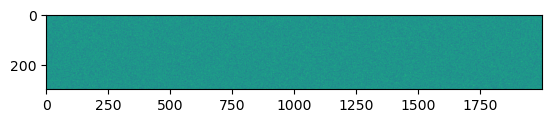

In [7]:
plt.imshow(fake_data_1)
plt.show()

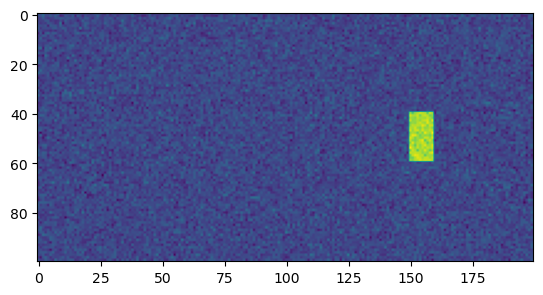

In [7]:
plt.imshow(fake_data_2)
plt.show()

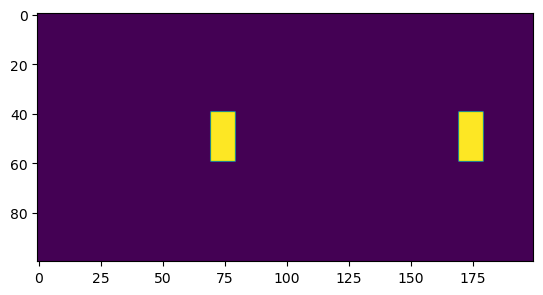

In [8]:
plt.imshow(fake_data_3)
plt.show()

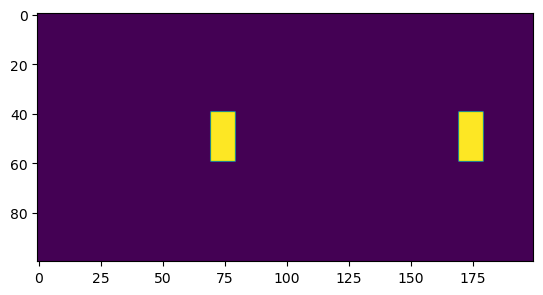

In [9]:
plt.imshow(fake_data_4)
plt.show()

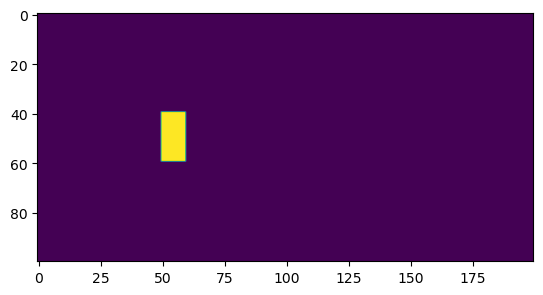

In [10]:
plt.imshow(fake_data_6)
plt.show()

In [6]:
# make weight matrix

w = 1./detector_variance.flatten()
W = diags(w, 0)

In [7]:
# define what we're decomposing

detector_measured = empirical_2d_array

In [8]:
time_00 = time.time()

time_0 = time.time()

A = A_mat

# compute matrices/vectors
ATW = A.T@W # A^T . W

time_1 = time.time()
print("Time:",time_1-time_0)
# -------------------------------------
time_0 = time.time()

#self.report(ATW, 'ATW')
#ATWA = ATW.dot(A) # A^T . W . A
ATWA = ATW@A # A^T . W . A

time_1 = time.time()
print("Time:",time_1-time_0)
# -------------------------------------
time_0 = time.time()

#self.report(ATWA, 'ATWA')
ATWx = ATW@detector_measured.flat

time_1 = time.time()
print("Time:",time_1-time_0)

time_0 = time.time()

thresh=3e-4

# compute damping coefficient
ATWAdiag = ATWA.diagonal()
damp = thresh * ATWAdiag.max()

time_1 = time.time()
print("Time:",time_1-time_0)

spec_lw, istop, itn, normr, normar, norma, conda, normx = \
          lsmr(ATWA, ATWx,
               damp=damp,
               )

time_11 = time.time()

print("Total time:", time_11-time_00)

Time: 0.42004990577697754
Time: 0.16860675811767578
Time: 0.010143041610717773
Time: 9.608268737792969e-05
Total time: 0.6028199195861816


Time: 0.0004227161407470703


In [14]:
np.shape(spec_lw)

(100,)

In [15]:
# rearrange 

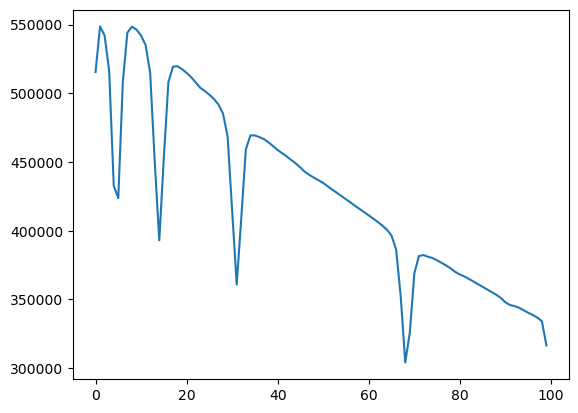

In [9]:
plt.clf()
plt.plot(spec_lw)
plt.savefig("test.png")
#plt.show()

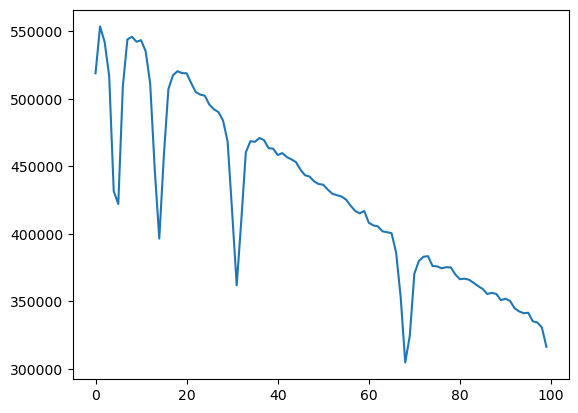

In [20]:
plt.clf()
plt.plot(spec_lw)
plt.savefig("test.png")
#plt.show()

In [31]:
plt.savefig(spec_lw, "extraction_small_footprint_equal_weights.png")

TypeError: savefig() takes 2 positional arguments but 3 were given

<Figure size 640x480 with 0 Axes>